# Task 7 - Personality Prediction

*by Lukas Dötlinger*


In [13]:
import pandas as pd
import numpy as np
import time

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


data = pd.read_csv('res/mbti_1.csv')

def filter_text(df, remove_labels=False):
    start_time = time.perf_counter()

    labels = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
    lower_labels = [ l.lower() for l in labels ]
    stopword_set = set(stopwords.words('english'))

    # Convert posts to lowercase.
    df['posts'] = df['posts'].apply(lambda s: s.lower())

    stop_time = time.perf_counter()
    print(f"Lowering took {stop_time - start_time:0.4f} seconds")
    start_time = stop_time

    # Word tokenize posts.
    df['posts'] = df['posts'].apply(lambda s: word_tokenize(s))

    stop_time = time.perf_counter()
    print(f"Tokenizing took {stop_time - start_time:0.4f} seconds")
    start_time = stop_time

    # Remove non-alpha words.
    df['posts'] = df['posts'].apply(lambda s: [ w for w in s if w.isalpha() ])
    # Remove personality labels.
    if remove_labels:
        df['posts'] = df['posts'].apply(lambda s: [ w for w in s if w not in lower_labels ])
    #Remove very short or long words.
    df['posts'] = df['posts'].apply(lambda s: [ w for w in s if len(w) > 3 ]) 
    df['posts'] = df['posts'].apply(lambda s: [ w for w in s if len(w) < 30 ])
    #Remove stopwords.
    df['posts'] = df['posts'].apply(lambda s: [ w for w in s if w not in stopword_set ])

    stop_time = time.perf_counter()
    print(f"Filtering took {stop_time - start_time:0.4f} seconds")
    start_time = stop_time

    # Join words to one string.
    df['posts'] = df['posts'].apply(lambda s: ' '.join(s))

    stop_time = time.perf_counter()
    print(f"Joining to string took {stop_time - start_time:0.4f} seconds")

    return df

processed_df = filter_text(data)
processed_df.head()

Lowering took 0.1075 seconds
Tokenizing took 57.4318 seconds
Filtering took 2.9267 seconds
Joining to string took 0.2190 seconds


,type,posts
0,INFJ,intj moments https sportscenter plays https ex...
1,ENTP,finding lack posts boring position often examp...
2,INTP,https course know blessing absolutely positive...
3,INTJ,intp enjoyed conversation esoteric gabbing nat...
4,ENTJ,another silly misconception approaching logica...


We inistially try to clean the data to remove anything that might not provide any information regarding an authors personality. As a fist step, the whole string is put to lower case,to generalize them. Afterwards `nltk.word_tokenize` is used to generate tokens. These are then further filtered to only get alphanumeric tokens. As a next step, we remove all stopwords, since they should in theory not provide any meaning. Additionally we remove any word, which is less than 3 or more than 30 characters long. Afterwards we join all tokens to a string and separate them using a whitespace.

It was observed that including stopwords and removing the word limitation, $3 < len(word) < 30$, yielded slightly worse results.

The function `filter_text` has the possibility to also filter MBTI labels from the texts. However, this reduced the accuracy of Logistic Regression from 61% to 46%.

In [16]:
encoder = LabelEncoder()
processed_df['encoding'] = encoder.fit_transform(processed_df['type'])
target = processed_df['encoding']

# Filter stopwords from nltk in vectorization step.
vectorizer = CountVectorizer() 
train = vectorizer.fit_transform(processed_df['posts'])

train.shape

(8675, 84182)

We can use `LabelEncoder` to create encodings for each MBTI type.

`CountVectorizer` then effectively creates a matrix of token counts over the whole vocabulary, as the text was already filterd before.

In [18]:
kf = KFold(n_splits=10)
results = {
    'accuracies': [],
    'f1-macro': [],
    'f1-micro': []
}

for train_index, test_index in kf.split(train):
    x_train, x_test = train[train_index], train[test_index]
    y_train, y_test = target[train_index], target[test_index]

    # Logistic Regression
    logreg = LogisticRegression(solver='saga', max_iter=100)
    logreg.fit(x_train, y_train)

    y_pred = logreg.predict(x_test)
    predictions = [round(value) for value in y_pred]

    # evaluate predictions
    results['accuracies'].append(accuracy_score(y_test, predictions))
    results['f1-macro'].append(f1_score(y_test, y_pred, average='macro'))
    results['f1-micro'].append(f1_score(y_test, y_pred, average='micro'))

print('----------------------------------------------------------------')
print('Accuracy: %.4f%%' % (sum(float(a) for a in results['accuracies']) / float(len(results['accuracies']))))
print('F1-macro: %.4f%%' % (sum(float(f) for f in results['f1-macro']) / float(len(results['f1-macro']))))
print('F1-micro: %.4f%%' % (sum(float(f) for f in results['f1-micro']) / float(len(results['f1-micro']))))



C:\Users\ldoet\scoop\apps\python\current\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ldoet\scoop\apps\python\current\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ldoet\scoop\apps\python\current\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ldoet\scoop\apps\python\current\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\ldoet\scoop\apps\python\current\lib\site-packages\sklearn\l

Using 10-Fold cross validation, we can observer the following results:

- Accuracy: 60.71%
- F1-macro: 46.93%
- F1-micro: 60.71%

The results look very good overall if we take into account that there are 16 different MBTI types.

Though we have to keep in mind that the data set is not really balanced. We might get different result for a more balanced data set. The distribution is displayed below.

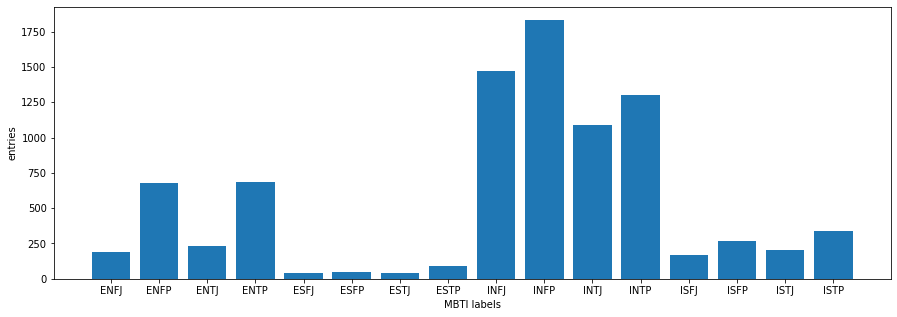

In [25]:
import matplotlib.pyplot as plt

data = pd.read_csv('res/mbti_1.csv')
counts = data.groupby(['type']).count()

plt.figure(figsize = (15, 5))
plt.bar(np.array(total.index), height = counts['posts'])
plt.xlabel('MBTI labels')
plt.ylabel('entries')
plt.show()